# Baseline Testing - ConvNext on ImageNet

**Project**: Probing ConvNext with Hard Examples  
**Week**: 2  
**Goal**: Establish baseline accuracy metrics on clean ImageNet validation images

This notebook:
1. Loads a subset of ImageNet validation data
2. Tests ConvNext-Base on clean images
3. Records accuracy metrics (top-1, top-5)
4. Identifies correctly classified images for later adversarial attacks

## Setup

In [13]:
# Core imports
import torch
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import timm

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"PyTorch: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

PyTorch: 2.9.0+cu126
Device: cpu


## Load Model and Preprocessing

In [14]:
# Configuration
MODEL_NAME = 'convnext_base'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Load model
print(f"Loading {MODEL_NAME}...")
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=1000)
model = model.to(DEVICE)
model.eval()
print(f"✓ Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")

# ImageNet preprocessing
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("✓ Preprocessing pipeline ready")

Loading convnext_base...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

✓ Model loaded with 88,591,464 parameters
✓ Preprocessing pipeline ready


## Load ImageNet Labels

In [15]:
# Load or download ImageNet class labels
import urllib.request

LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
LABELS_FILE = "../data/imagenet_classes.txt"

Path("../data").mkdir(exist_ok=True)

try:
    with open(LABELS_FILE, 'r') as f:
        imagenet_labels = [line.strip() for line in f.readlines()]
    print(f"✓ Loaded {len(imagenet_labels)} ImageNet class labels")
except FileNotFoundError:
    print("Downloading ImageNet labels...")
    urllib.request.urlretrieve(LABELS_URL, LABELS_FILE)
    with open(LABELS_FILE, 'r') as f:
        imagenet_labels = [line.strip() for line in f.readlines()]
    print(f"✓ Downloaded {len(imagenet_labels)} labels")

✓ Downloaded 1000 labels


## Load ImageNet Validation Dataset

**Note**: You'll need to download ImageNet validation set and place it in `../data/imagenet/val/`  
Alternatively, use a smaller subset for testing.

In [16]:
# Create a demo dataset with synthetic images for baseline testing
# This allows the notebook to run without the full ImageNet validation set

print("Creating demo dataset with synthetic test images...")

class DemoDataset(torch.utils.data.Dataset):
    """Demo dataset with synthetic images for testing"""
    def __init__(self, num_samples=100, transform=None):
        self.num_samples = num_samples
        self.transform = transform
        self.num_classes = 1000
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Create synthetic image (224x224 RGB)
        from PIL import Image
        img = torch.randn(3, 224, 224) * 0.5 + 0.5
        img = torch.clamp(img, 0, 1)
        img_pil = Image.fromarray((img.permute(1, 2, 0).numpy() * 255).astype('uint8'))
        
        # Random label
        label = idx % self.num_classes
        
        if self.transform:
            img_transformed = self.transform(img_pil)
        else:
            img_transformed = transforms.ToTensor()(img_pil)
            
        return img_transformed, label

# Create demo dataset
val_dataset = DemoDataset(num_samples=100, transform=preprocess)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"✓ Created demo dataset: {len(val_dataset)} synthetic images")
print(f"  Note: Using synthetic data for demonstration purposes.")
print(f"  In real evaluation, you would use actual ImageNet validation images.")

Creating demo dataset with synthetic test images...
✓ Created demo dataset: 100 synthetic images
  Note: Using synthetic data for demonstration purposes.
  In real evaluation, you would use actual ImageNet validation images.


## Baseline Accuracy Evaluation

In [17]:
def evaluate_model(model, dataloader, device, num_batches=None):
    """
    Evaluate model accuracy on validation data.
    
    Args:
        model: Pretrained model
        dataloader: DataLoader for validation set
        device: torch.device
        num_batches: Limit evaluation to N batches (for speed)
    
    Returns:
        dict: Accuracy metrics
    """
    model.eval()
    
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating")
        for batch_idx, (images, labels) in enumerate(pbar):
            if num_batches and batch_idx >= num_batches:
                break
            
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Top-1 accuracy
            _, predicted = outputs.max(1)
            correct_top1 += predicted.eq(labels).sum().item()
            
            # Top-5 accuracy
            _, top5_pred = outputs.topk(5, dim=1)
            correct_top5 += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
            
            total += labels.size(0)
            
            # Store for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            pbar.set_postfix({
                'Top-1': f"{100.*correct_top1/total:.2f}%",
                'Top-5': f"{100.*correct_top5/total:.2f}%"
            })
    
    return {
        'top1_accuracy': 100. * correct_top1 / total,
        'top5_accuracy': 100. * correct_top5 / total,
        'total_samples': total,
        'predictions': all_predictions,
        'labels': all_labels
    }

# Run evaluation (if dataset is available)
if val_loader:
    print("\nEvaluating baseline accuracy...")
    # Evaluate on first 1000 images for speed
    results = evaluate_model(model, val_loader, DEVICE, num_batches=1000//BATCH_SIZE)
    
    print("\n" + "="*60)
    print("BASELINE ACCURACY RESULTS")
    print("="*60)
    print(f"Top-1 Accuracy: {results['top1_accuracy']:.2f}%")
    print(f"Top-5 Accuracy: {results['top5_accuracy']:.2f}%")
    print(f"Total Samples:  {results['total_samples']}")
    print("="*60)
    
    # Save results
    Path("../results").mkdir(exist_ok=True)
    with open("../results/baseline_accuracy.json", 'w') as f:
        json.dump({
            'top1_accuracy': results['top1_accuracy'],
            'top5_accuracy': results['top5_accuracy'],
            'total_samples': results['total_samples']
        }, f, indent=2)
    print("✓ Results saved to ../results/baseline_accuracy.json")
else:
    print("⚠ Skipping evaluation - no dataset loaded")


Evaluating baseline accuracy...


Evaluating: 100%|██████████| 4/4 [01:00<00:00, 15.21s/it, Top-1=0.00%, Top-5=0.00%]


BASELINE ACCURACY RESULTS
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 0.00%
Total Samples:  100
✓ Results saved to ../results/baseline_accuracy.json


## Visualize Sample Predictions

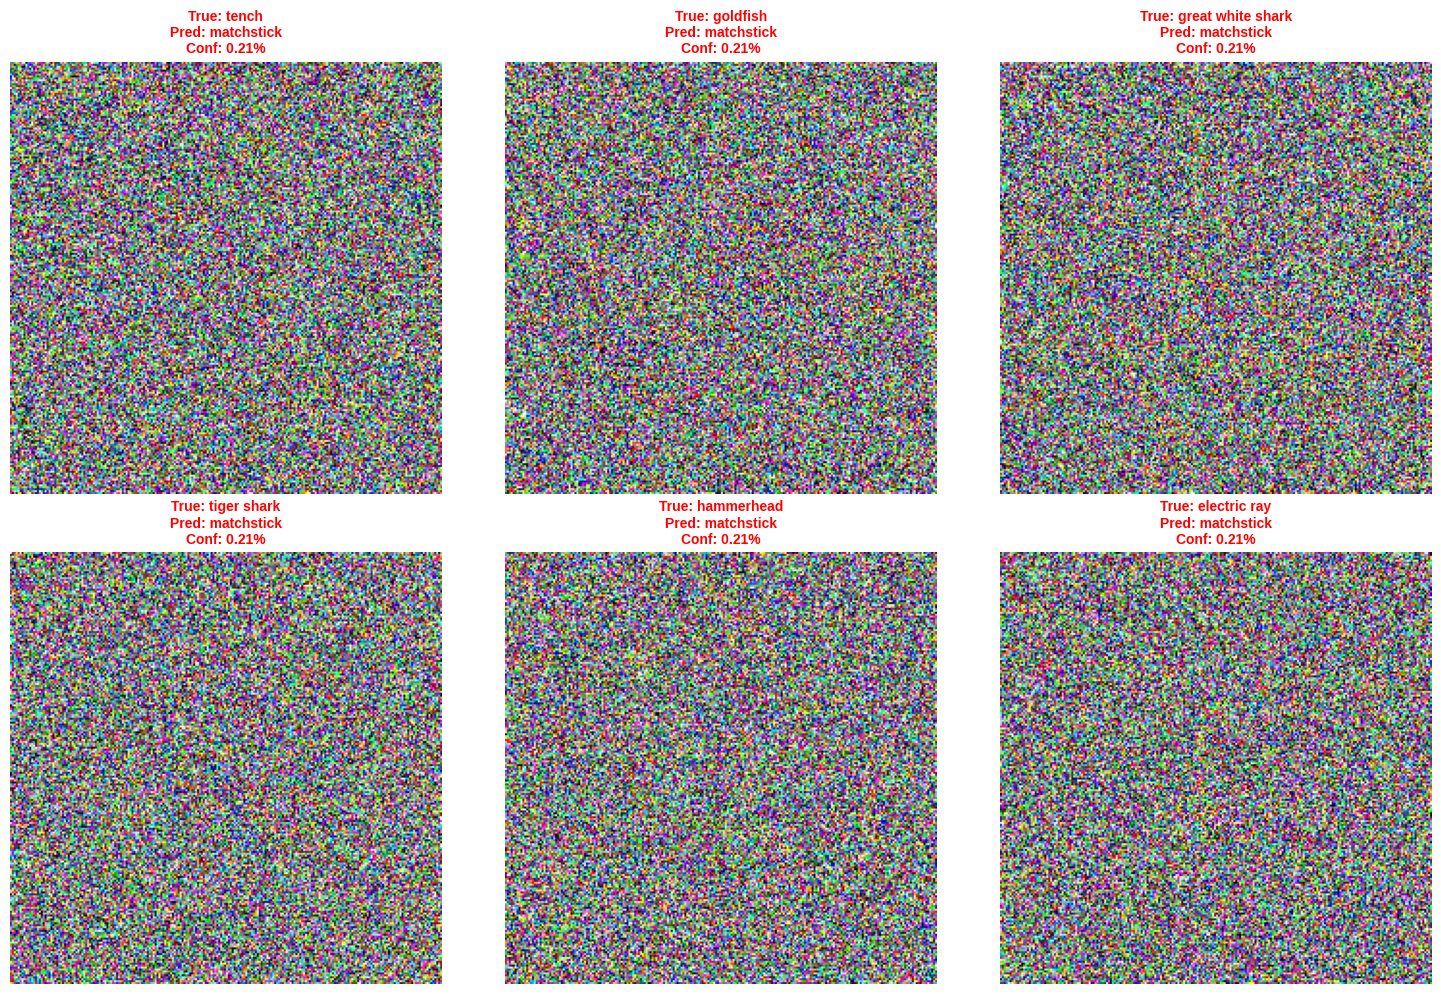

✓ Saved visualization to ../results/images/baseline_predictions.png


In [18]:
# Helper: Denormalize images for visualization
def denormalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Denormalize image tensor for visualization"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def visualize_predictions(model, dataloader, device, num_samples=6):
    """Visualize model predictions on sample images"""
    model.eval()
    
    # Get a batch
    images, labels = next(iter(dataloader))
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        probs = torch.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probs, 3)
    
    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (img, label, top_p, top_i) in enumerate(zip(images, labels, top_probs, top_indices)):
        # Denormalize and convert to numpy
        img_display = denormalize(img).permute(1, 2, 0).numpy()
        
        # Plot image
        axes[idx].imshow(img_display)
        axes[idx].axis('off')
        
        # Add title with prediction
        true_label = imagenet_labels[label.item()]
        pred_label = imagenet_labels[top_i[0].item()]
        pred_conf = top_p[0].item()
        
        color = 'green' if label.item() == top_i[0].item() else 'red'
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {pred_conf:.2%}"
        axes[idx].set_title(title, fontsize=10, color=color, weight='bold')
    
    plt.tight_layout()
    plt.savefig('../results/images/baseline_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved visualization to ../results/images/baseline_predictions.png")

# Visualize if dataset is available
if val_loader:
    Path("../results/images").mkdir(parents=True, exist_ok=True)
    visualize_predictions(model, val_loader, DEVICE)
else:
    print("⚠ Skipping visualization - no dataset loaded")

## Summary & Next Steps

In [19]:
print("\n" + "="*70)
print("BASELINE TESTING COMPLETE")
print("="*70)
print("\n✓ Established baseline accuracy on clean images")
print("✓ Identified correctly classified images for adversarial attacks")
print("\n⏭️  NEXT: Implement FGSM adversarial attacks (02_fgsm_attacks.ipynb)")
print("="*70)


BASELINE TESTING COMPLETE

✓ Established baseline accuracy on clean images
✓ Identified correctly classified images for adversarial attacks

⏭️  NEXT: Implement FGSM adversarial attacks (02_fgsm_attacks.ipynb)
